# Task 3
# Sentiment Analysis

Nixon Andika / 13517059  
Ferdy Santoso / 13517116  
Jan Meyer Saragih / 13517131

## Imports

In [3]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import string
import tensorflow as tf
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import pickle
from pattern.en import spelling

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Constants

In [4]:
sentence_len = 50
unique_word_len = 500
test_size = 0.1
val_size = 0.15
embedding_size = 256
dropout = 0.2
epoch_count = 10

## Helper Functions

### Save Load Prep Data

In [2]:
def save_prep_data():
    pickle.dump(x_train_prep, open('data/x_train_prep.txt', 'wb'))
    pickle.dump(x_val_prep, open('data/x_val_prep.txt', 'wb'))
    pickle.dump(x_test_prep, open('data/x_test_prep.txt', 'wb'))
    pickle.dump(y_train, open('data/y_train.txt', 'wb'))
    pickle.dump(y_val, open('data/y_val.txt', 'wb'))
    pickle.dump(y_test, open('data/y_test.txt', 'wb'))

def load_prep_data():
    x_train_prep = pickle.load(open('data/x_train_prep.txt', 'rb'))
    x_val_prep = pickle.load(open('data/x_val_prep.txt', 'rb'))
    x_test_prep = pickle.load(open('data/x_test_prep.txt', 'rb'))
    y_train = pickle.load(open('data/y_train.txt', 'rb'))
    y_val = pickle.load(open('data/y_val.txt', 'rb'))
    y_test = pickle.load(open('data/y_test.txt', 'rb'))
    return x_train_prep, x_val_prep, x_test_prep, y_train, y_val, y_test

## Preprocessing

### Read Data

In [47]:
# Read CSV
df = pd.read_csv('./data/data_3.csv')

In [48]:
# Handle columns
df = df[['review', 'rating']]

In [49]:
# Drop NaNs
df.dropna(inplace = True) 

In [50]:
df['rating'] = df['rating'].replace({ 'Recommended':1, 'Not Recommended': 0})
df

,review,rating
0,My first game on A3 brought me the most horrif...,1
1,This is not a game for people who want fast ac...,1
2,Oh man. Where to even begin with this one. It ...,1
3,This is quite possibly the most emotional shoo...,1
4,"If you have friends, this is a great game to p...",1
...,...,...
79432,This is my life!. MY GAME!,1
79433,Even with all unusual style and gameplay this ...,0
79434,i more of a fan of first person shooter and al...,0
79435,My friends have been going on and on about thi...,0


### Balancing Data

In [51]:
# Oversampling
max_size = df['rating'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('rating'):
    lst.append(group.sample(max_size-len(group), replace=True))
df = pd.concat(lst)

In [52]:
# Reset index, shuffle
df = df.sample(frac=1).reset_index(drop=True)
df

,review,rating
0,"Paid mods, why bother?",0
1,"For 3 years and still, can make you play for h...",1
2,Take forever and a day to re-release this on P...,0
3,I don't get it. League of Legends I eventually...,0
4,"It's full of 5 year olds, has helped me meet s...",1
...,...,...
134765,LOVE IT,1
134766,Its a Great game highly suggest this game for ...,1
134767,pre-ordered the game. waited for days for it t...,0
134768,"Its quite good yes i know, i played it for 12 ...",0


### Check Data Balance

<AxesSubplot:>

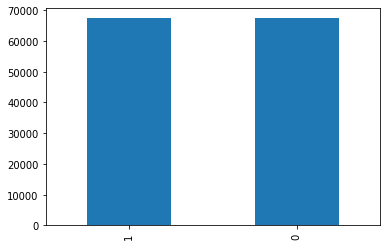

In [53]:
df['rating'].value_counts().plot.bar()

### Train Test Validation Split

#### Get Train Data

In [54]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.1, random_state=3)
for train_idx, test_idx in sss.split(df['review'], df['rating']):
    x_train, x_test = df['review'][train_idx], df['review'][test_idx]
    y_train, y_test = df['rating'][train_idx], df['rating'][test_idx]
    
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

x_train

0         Having to pay for mods will ruin the community...
1         Absolutely fantastic game, one which lasted so...
2         The game runs at 40 fps and microstutters all ...
3         Nice game takes a lot of time to create good s...
4         worth the 60.00 dont see why theres so many ne...
                                ...                        
121288    Play it, and join my clan :D ( The Cult Of Sat...
121289    This game is honestly awesome. The story is gr...
121290    One of most beautiful games of our time. The h...
121291    it's the best game ever people who say that it...
121292    I never expected to see this extraordinary amm...
Name: review, Length: 121293, dtype: object

#### Get Test Data

In [55]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.15, random_state=3)
for train_idx, val_idx in sss.split(x_train, y_train):
    idx_train = train_idx
    idx_val = val_idx

y_val = y_train[idx_val]
x_val = x_train[idx_val]
x_train_train = x_train[idx_train]
y_train_train = y_train[idx_train]
x_train = x_train_train
y_train = y_train_train

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

x_train

0           Essentially Minecraft on steroids. (Not really)
1         C*ckstar don't give a f*ck about their customers.
2                                                 Nice game
3         Got forced by my friend to download 20 GBs of ...
4                            VAC banned for being too good.
                                ...                        
103094    Gta online is kinda of boring, and is to hard ...
103095    I like military sim games and this one has a l...
103096                       It's Dota. It's can't be good.
103097    This game is awesome, it's a blast to play... ...
103098    Possibly the worst game created so far, even c...
Name: review, Length: 103099, dtype: object

## NLP Preprocessing

### Tokenization Remove Unnecessary Information

In [56]:
# Eksekusi preprocess untuk satu row data
def execute_preprocess(value):
    # Mendapatkan token seperti kata, tanda baca dari kalimat
    tokenList = word_tokenize(value)
    tokenList = [w.lower() for w in tokenList]

    # Menghilangkan stopwords dalam bahasa Inggris untuk mengurangi jumlah token yang diproses
    stop_words = set(stopwords.words('english'))
    tokenList = [word for word in tokenList if not word in stop_words]
    
    # Menggabungkan semua token menjadi 1 kalimat panjang dengan setiap token dipisahkan oleh spasi
    result = ""
    for token in tokenList:
        if token != "":
            result += token + ' '
    result = result[:-1]
    
    # Remove multiple space and tokens
    result = re.sub(r'[?=.*\!-_,\.]','',result)
    result = re.sub(' +', ' ', result)
    
    return result

# Preprocess setiap baris untuk setiap row dalam data
def preprocess_data(raw_data):
    tokens = []
    for raw in raw_data:
        tokenList = execute_preprocess(raw)
        tokens.append(tokenList)
    return tokens

In [57]:
x_train_prep = preprocess_data(x_train)
x_val_prep = preprocess_data(x_val)
x_test_prep = preprocess_data(x_test)

x_train_prep

['essentially minecraft steroids really ',
 'c ckstar nt give f ck customers ',
 'nice game',
 'got forced friend download gbs mods would download gigs ',
 'vac banned good ',
 'gta v reviewed played many vast majority gamers worked smoothly given great single multiplayer experience however well good found game absoloutly riddled bugs framerate issus login errors game even recognizeed downloaded recently fairly high end gpu moderatly strong cpu still experience drops fps way constant basis emailing rockstar support issue ended apologising problems offering support fixes time writing m really unhappy game ve spent hours searching youtube videos online forums asking friends advice avail current issue rockstar s social club failed update even reinstalling program know m tiny minority huge amount people playing game significant problems like mine somethiing really needs done probably wo nt experience issues know many people friends list nt game pretty much unplayable ',
 'matchmaking game 

In [6]:
x_train_prep, x_val_prep, x_test_prep, y_train, y_val, y_test = load_prep_data()
y_train

0         1
1         0
2         1
3         1
4         0
         ..
103094    0
103095    0
103096    0
103097    0
103098    0
Name: rating, Length: 103099, dtype: int64

## Feature Extraction (TF-IDF)

### Fitting

In [12]:
tfidf = TfidfVectorizer(binary=True, use_idf = True, max_features=256)
tfidf = tfidf.fit(x_train_prep)
tfidf

TfidfVectorizer(binary=True, max_features=256)

### Extracting

In [13]:
x_train_tfidf = pd.DataFrame(tfidf.transform(x_train_prep).toarray(), columns=[tfidf.get_feature_names()])
x_val_tfidf = pd.DataFrame(tfidf.transform(x_val_prep).toarray(), columns=[tfidf.get_feature_names()])
x_test_tfidf = pd.DataFrame(tfidf.transform(x_test_prep).toarray(), columns=[tfidf.get_feature_names()])

x_train_tfidf

,able,actually,add,almost,already,also,always,amazing,amount,another,...,workshop,world,worst,worth,would,wrong,year,years,yes,yet
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.545233,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103094,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
103095,0.000000,0.0,0.0,0.184448,0.0,0.0,0.177109,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.123146,0.0,0.0,0.0,0.0,0.0
103096,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
103097,0.254663,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## Classification 1: Support Vector Machine (SVM)

### Training

In [24]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train_tfidf[:50000], y_train[:50000])

SVC()

### Testing

In [25]:
y_test_predict = clf.predict(x_test_tfidf)
y_test_predict

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [26]:
accuracy = accuracy_score(y_test, y_test_predict)
accuracy

0.905097573643986

### Save Model

In [27]:
svm_file = 'model/svm_2.txt'
pickle.dump(clf, open(svm_file, 'wb'))

## Classification 2: Deep Neural Network (DNN)

### Word To Vec

In [40]:
tokenizer = Tokenizer(num_words = unique_word_len, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token='<<OOV>>')
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train_prep)
x_val = tokenizer.texts_to_sequences(x_val_prep)
x_test = tokenizer.texts_to_sequences(x_test_prep)

x_train

[[1, 134, 1, 153],
 [1, 347, 1, 378, 53, 1, 1, 347, 409, 102, 85, 1, 1, 1, 1, 1, 1, 53, 201, 215],
 [44,
  68,
  33,
  122,
  26,
  1,
  73,
  1,
  1,
  1,
  449,
  1,
  1,
  126,
  122,
  1,
  335,
  1,
  228,
  6,
  59,
  111,
  1,
  1,
  162,
  210],
 [434,
  6,
  34,
  1,
  434,
  34,
  1,
  434,
  149,
  462,
  1,
  136,
  1,
  1,
  1,
  136,
  151,
  237,
  1,
  6,
  34,
  1,
  1,
  1,
  1,
  1,
  1,
  117,
  1,
  1,
  1,
  1,
  108,
  26,
  1,
  1,
  1,
  340,
  1,
  53,
  1,
  6,
  34,
  1,
  1,
  1,
  1,
  34,
  1,
  1,
  153,
  166,
  1,
  168,
  95,
  156,
  179,
  462,
  123,
  44,
  1,
  1,
  95,
  1,
  434,
  1,
  1,
  1,
  1,
  1,
  1],
 [29,
  440,
  6,
  1,
  123,
  1,
  6,
  1,
  1,
  396,
  106,
  1,
  267,
  334,
  1,
  70,
  113,
  106,
  345,
  294,
  1,
  1],
 [95,
  1,
  86,
  85,
  1,
  268,
  1,
  1,
  1,
  1,
  33,
  167,
  1,
  1,
  1,
  70,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  337,
  367,
  1,
  378,
  1,
  337,
  1,
  1,
  259,
  170,
  469,
  1,

### Padding

In [41]:
x_train_padded = pad_sequences(x_train, maxlen = sentence_len, padding="pre", truncating="post")
x_val_padded = pad_sequences(x_val, maxlen = sentence_len, padding="pre", truncating="post")
x_test_padded = pad_sequences(x_test, maxlen = sentence_len, padding="pre", truncating="post")

y_train

0         1
1         0
2         1
3         1
4         0
         ..
103094    0
103095    0
103096    0
103097    0
103098    0
Name: rating, Length: 103099, dtype: int64

## Model Building

### Configs

In [17]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_accuracy', patience = 2)
callback = [early_stopping]

### Building Model

In [45]:
model = Sequential()
model.add(Embedding(input_dim = unique_word_len, output_dim = embedding_size, input_length = sentence_len))
model.add(LSTM(128, dropout = dropout, recurrent_dropout = dropout))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 256)           128000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 325,249
Trainable params: 325,249
Non-trainable params: 0
_________________________________________________________________


## Training

In [43]:
print(x_train_padded.shape, x_val_padded.shape, x_test_padded.shape)

(103099, 50) (18194, 50) (13477, 50)


### Training

In [46]:
history = model.fit(x_train_padded, y_train, validation_data=(x_val_padded, y_val), \
                    epochs = epoch_count, batch_size = 64)

Epoch 1/10
1611/1611 [==============================] - 262s 163ms/step - loss: 5.9605e-08 - accuracy: 0.4630 - val_loss: 5.9605e-08 - val_accuracy: 0.4589
Epoch 2/10
1611/1611 [==============================] - 265s 165ms/step - loss: 5.9605e-08 - accuracy: 0.4623 - val_loss: 5.9605e-08 - val_accuracy: 0.4589
Epoch 3/10
1611/1611 [==============================] - 258s 160ms/step - loss: 5.9605e-08 - accuracy: 0.4621 - val_loss: 5.9605e-08 - val_accuracy: 0.4589
Epoch 4/10
1611/1611 [==============================] - 262s 163ms/step - loss: 5.9605e-08 - accuracy: 0.4637 - val_loss: 5.9605e-08 - val_accuracy: 0.4589
Epoch 5/10
 552/1611 [=========>....................] - ETA: 2:53 - loss: 5.9237e-08 - accuracy: 0.4624

KeyboardInterrupt: 

In [33]:
y_pred=(model.predict(x_test_padded)).astype("int32")
y_pred

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [ ]:
print(len(history.history['loss']))
plt.plot(range(1, epoch_count + 1), history.history['accuracy'], 'r--')
plt.plot(range(1, epoch_count + 1), history.history['val_accuracy'], 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
filename = 'model/model1'
pickle.dump(model, open(filename, 'wb'))